# Imports

Mount το google drive. Το κάνουμε αυτό για έχουμε πρόσβαση στα python modules που χρειαζόμαστε.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Το συνδέουμε με το folder του συγκεκριμένου εργαστηρίου

In [3]:
import sys
sys.path.insert(0,'/content/drive/My Drive/Lab_DL_ex1')

Εγκαθιστούμε τις απαραίτητες βιβλιοθήκες

In [4]:
import sys
# !{sys.executable} -m pip install torch==1.10.1 torchvision==0.11.2 torchaudio==0.10.1
!{sys.executable} -m pip install torch torchvision torchaudio

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

### Οδηγίες

Σε αυτή την εργασία θα κάνετε τα εξής:
1. Δοκιμή τουλάχιστον των 3 καλύτερων συνδυασμών των παραμέτρων width και depth του Δικτύου wideResNet σύμφωνα με αυτά που προτείνονται και στο paper (results with moderate data augmentation)

2. Regularization. Το δίκτυο έχει μηχανισμό ομαλοποίησης (Dropout). Δοκιμάστε να προσθέσετε το Dropout (παράμετρος droprate) όπως αναφέρει το paper και καταγράψτε τα αποτελέσματα για τα παραπάνω μοντέλα.

3. Κρατώντας τις παραμέτρους του δικτύου με τα καλύτερα αποτελέσματα (load best model από το 1 και 2) θα κάνετε test στο CIFAR-C. Έπειτα, θα εφαρμόσετε τη μέθοδο mixup (συμπληρώστε τον κώδικα στο κελί με το CifarDataset) κάντε εκ νέου την εκπαίδευση και καταγράψτε τα αποτελέσματα.

4. (Bonus) Κάντε επίσης ένα plot των confidence scores (softmax predictions) και συγκρίνετε το με το αντίστοιχο plot όταν το μοντέλο δεν είχε mixup. Τι παρατηρείτε?

Tip: Για το κάθε πείραμα (training) μην το τρέξετε πάνω από 20 εποχές


Ορισμένα κελιά κώδικα παρέχονται για εσάς σε αυτό το notebook. Θα πρέπει να αποφύγετε την επεξεργασία του παρεχόμενου κώδικα και να φροντίσετε να εκτελέσετε τα κελιά για να αποφύγετε απροσδόκητα σφάλματα. Ορισμένα κελιά ξεκινούν με τη γραμμή:

΄#### GRADED CELL ####`
Αυτά θα βαθμολογηθούν. Φρόντιστε για κάθε κελί να δικαιολογείτε με σχόλια τις επιλογές σας.


### Ας ξεκινήσουμε!

Θα ξεκινήσουμε την εκτέλεση ορισμένων imports και τη φόρτωση του συνόλου δεδομένων. Μην επεξεργαστείτε τα υπάρχοντα imports στο παρακάτω κελί. Εάν θέλετε να κάνετε περαιτέρω imports, θα πρέπει να τα προσθέσετε εδώ.

Φορτώνουμε τις απαραίτητες βιβλιοθήκες

In [5]:
import numpy as np
import time
import torch
import torch.nn.functional as F
from torchvision import transforms
from torchvision import datasets
import torch.nn as nn
import torch.optim
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
import pickle
import random
from wideresnet import WideResNet
import logging
import shutil
import os
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd


torch.manual_seed(0)
np.random.seed(0)


In [6]:
data_dir = "/content/drive/My Drive/Lab_DL_ex1/data"

Δημιουργία φακέλου στο οποίο θα κρατάμε τα log files των πειραμάτων

In [7]:
exp_name = "/content/drive/My Drive/Lab_DL_ex1/Lab_1_DL_wrn_log"


exp_dir = os.path.join('Cifar', exp_name)

if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)


logfile = open(os.path.join(exp_dir, 'log'), 'w')

# Μέρος 1

## Functions

### construct_datasets

Στο παρακάτω κελί θα δημιουργήσουμε το train και validation loader χρησιμοποιώντας τη συνάρτηση construct_datasets

In [ ]:
def construct_datasets(data_dir, batch_size):
    def data2loader_train(tr_data):
        train_loader = torch.utils.data.DataLoader(
            tr_data,
            batch_size=batch_size,
            shuffle=True)
        return train_loader

    def data2loader_test(te_data):
        test_loader = torch.utils.data.DataLoader(
            te_data,
            batch_size=batch_size,
            shuffle=False)

        return test_loader

    to_tensor = transforms.ToTensor()
    normalize = transforms.Normalize([0.5] * 3, [0.5] * 3)
    train_transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.RandomCrop(32, padding=4),
         transforms.ToTensor(), normalize])

    test_transform = transforms.Compose(
        [transforms.ToTensor(), normalize])

    train_data = datasets.CIFAR10(
        os.path.join(data_dir, 'cifar'), train=True, transform=train_transform, download=True)
    test_data = datasets.CIFAR10(
        os.path.join(data_dir, 'cifar'), train=False, transform=test_transform, download=True)
    print("Train set number of items ", len(train_data))
    print("Val set number of items ", len(test_data))

    return data2loader_train(train_data), data2loader_test(test_data)

In [ ]:
batch_size = 128
train_loader, val_loader = construct_datasets(data_dir, batch_size)

Files already downloaded and verified
Files already downloaded and verified
Train set number of items  50000
Val set number of items  10000


### utils

Σε αυτό το σημείο θα ορίσουμε το μοντέλο (Wide Residual Network), τη loss function και τον scheduler αυτής και τον optimizer

In [ ]:
def save_checkpoint(state, dataset, exp_name, filename='checkpoint.pth.tar'):
    """Saves checkpoint to disk"""
    directory = "/content/drive/My Drive/Lab_DL_ex1/runs/%s/%s/" % (dataset, exp_name)
    if not os.path.exists(directory):
        os.makedirs(directory)
    filename = directory + filename
    torch.save(state, filename)


def bceloss(x, y):
    eps = 1e-6
    return -torch.mean(y * torch.log(x + eps) + (1 - y) * torch.log(1 - x + eps))

def cross_entropy(pred, soft_targets):
    logsoftmax = nn.LogSoftmax()
    return torch.mean(torch.sum(- soft_targets * logsoftmax(pred), 1))


def get_lr(step, total_steps, lr_max, lr_min):
  """Compute learning rate according to cosine annealing schedule."""
  return lr_min + (lr_max - lr_min) * 0.5 * (1 +
                                             np.cos(step / total_steps * np.pi))

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

### test_cifar, test_c_cifar

In [ ]:
def test_cifar(test_loader, net):
    """Evaluate network on given dataset."""
    net.eval()
    params = list(net.parameters())
    total_loss = 0.
    total_correct = 0
    with torch.no_grad():
        for images, targets in test_loader:
            targets = targets.cuda(non_blocking=True).long()
            images = images.cuda(non_blocking=True).float()
            logits = net(images)

            loss = F.cross_entropy(logits, targets)
            pred = logits.data.max(1)[1]
            total_loss += float(loss.data)
            total_correct += pred.eq(targets.data).sum().item()
    #print("len(test_loader.dataset)", len(test_loader.dataset))
    return total_loss / len(test_loader.dataset), total_correct / len(test_loader.dataset)


def test_c_cifar(net):
    """Evaluate network on given corrupted dataset."""
    base_path = '/content/drive/My Drive/Lab_DL_ex1/data/cifar/CIFAR-10-C/'
    normalize = transforms.Normalize([0.5] * 3, [0.5] * 3)
    test_transform = transforms.Compose(
        [transforms.ToTensor(), normalize])
    test_data = datasets.CIFAR10(
        '/content/drive/My Drive/Lab_DL_ex1/data/cifar/', train=False, transform=test_transform)
    corruption_accs = []
    Weather_accs = []
    Blur_accs = []
    Noise_accs = []
    Digital_accs = []
    weather_corr = ['snow', 'frost', 'fog']
    blur_corr = ['defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur']
    noise_corr = ['gaussian_noise', 'shot_noise', 'impulse_noise']
    digital_corr = ['brightness', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression']

    for corruption in CORRUPTIONS:
        # Reference to original data is mutated
        test_data.data = np.load(base_path + corruption + '.npy')[-10000:]  # take the level 5 severity only
        #pdb.set_trace()
        test_data.targets = torch.LongTensor(np.load(base_path + 'labels.npy')[-10000:])

        test_loader = torch.utils.data.DataLoader(
            test_data,
            batch_size=batch_size,
            shuffle=False,
            #num_workers=4,
            pin_memory=True)
        test_loss, test_acc = test_cifar(test_loader, net)
        corruption_accs.append(test_acc)
        if corruption in weather_corr:
            Weather_accs.append(test_acc)
        elif corruption in blur_corr:
            Blur_accs.append(test_acc)
        elif corruption in noise_corr:
            Noise_accs.append(test_acc)
        elif corruption in digital_corr:
            Digital_accs.append(test_acc)


        #print('{}\n\tTest Loss {:.3f} | Test Acc {:.3f}'.format(
        #    corruption, test_loss, test_acc))
    print('{}\n\t Test Acc {:.3f}'.format(
        'Weather', np.mean(np.array(Weather_accs))))
    print('{}\n\t Test Acc {:.3f}'.format(
        'Blur', np.mean(np.array(Blur_accs))))
    print('{}\n\t Test Acc {:.3f}'.format(
        'Noise', np.mean(np.array(Noise_accs))))
    print('{}\n\t Test Acc {:.3f}'.format(
        'Digital', np.mean(np.array(Digital_accs))))
    all_accs = []
    all_accs.append(np.mean(np.array(Weather_accs)))
    all_accs.append(np.mean(np.array(Blur_accs)))
    all_accs.append(np.mean(np.array(Noise_accs)))
    all_accs.append(np.mean(np.array(Digital_accs)))

    return np.mean(np.array(all_accs))

### train_model

In [ ]:
def train_model(num_iters, train_loader, model):

  # Train loop

  for t in range( 0, num_iters+1 ):

    losses = AverageMeter()
    top1 = AverageMeter()
    model.train()

    try:
        input, target = next(train_loader_iter)
    except:
        train_loader_iter = iter(train_loader)
        input, target = next(train_loader_iter)
    input, target = input.cuda(non_blocking=True).float(), target.cuda(non_blocking=True).long()

    params = list(model.parameters())
    output = model(input)
    ce_loss = criterion(output, target)
    #ce_loss = criterion(output, target)


    optimizer.zero_grad()
    ce_loss.backward()
    optimizer.step()
    scheduler.step()


      # measure accuracy and record loss
    prec1 = accuracy(output, target, topk=(1,))[0]
    losses.update(ce_loss.data.item(), input.size(0))
    top1.update(prec1.item(), input.size(0))



    if t % print_freq == 0 and t >= print_freq:

        loss1, prec1 = test_cifar(val_loader, model)
        #print("Epoch ", epoch)
        print("Validation set acc", prec1)
        logfile.write('validation set acc: ' + str(prec1) + '\n')
        #print('Average Cifar-C accuracy {}'.format(test_c_cifar(model)))
        print('----------')


  # validate_all(model, args.data_dir, exp_name, args.batch_size, logfile, t, kwargs)

  print('Cifar accuracy {}'.format(test_cifar(val_loader, model)))
  logging.info(f'avg acc {test_cifar(val_loader, model)}')
  logfile.write(str(t) + ' Val acc: ' + str(test_cifar(val_loader, model)) + '\n')
  logfile.close()

## epochs, iters, batch size, print freq

Ζητούμενο 1 και 2.

Στο παρακάτω κελί φαίνεται ένα παράδειγμα ενός wide residual network.
Διαβάζοντας το paper θα πρέπει να βρείτε τις παραμέτρους για τα 3 καλύτερα μοντέλα που προτείνονται στο paper.

Χρησιμοποιείστε το παρακάτω κελί ως template και σχολιάστε τις επιλογές σας σε markdown κελί κάνοντας αναφορά στο paper.

In [ ]:
num_epochs = 20

num_iters = 391 * num_epochs  # number of total epochs to run

batch_size = 128

print_freq = 391 # evaluation frequency (and log) (every epoch)

## WRN-40-4 without dropout

In [ ]:
#### GRADED CELL ####

# Complete the following parameters and run the cell

# Model Parameters cell 1

layers = 40 # total number of layers of wrn (wide residual network)
num_classes = 10   # Number of classes of th CIFAR dataset
widen_factor = 4
droprate = 0 #  Dropout probability for regularization
lr = 0.1  # learning rate
weight_decay = 0.0005

model1_nodropout = WideResNet(layers, num_classes, widen_factor, droprate)


model1_nodropout = model1_nodropout.cuda()

criterion = nn.CrossEntropyLoss().cuda()

optimizer = torch.optim.SGD(model1_nodropout.parameters(), lr, momentum=0.9, nesterov=True,
                                    weight_decay=weight_decay)
# scheduler_theta = torch.optim.lr_scheduler.StepLR(optimizer, step_size=60)
scheduler = torch.optim.lr_scheduler.LambdaLR(
  optimizer,
  lr_lambda=lambda step: get_lr(
      step,
      num_iters,
      1,
      1e-6 / lr))

logfile = open(os.path.join(exp_dir, 'log'), 'a')
train_model(num_iters, train_loader, model1_nodropout)

Validation set acc 0.5929
----------
Validation set acc 0.7076
----------
Validation set acc 0.7123
----------
Validation set acc 0.7558
----------
Validation set acc 0.8142
----------
Validation set acc 0.7739
----------
Validation set acc 0.8266
----------
Validation set acc 0.8282
----------
Validation set acc 0.8596
----------
Validation set acc 0.8689
----------
Validation set acc 0.8578
----------
Validation set acc 0.8812
----------
Validation set acc 0.8969
----------
Validation set acc 0.9081
----------
Validation set acc 0.9074
----------
Validation set acc 0.9188
----------
Validation set acc 0.9242
----------
Validation set acc 0.9285
----------
Validation set acc 0.9296
----------
Validation set acc 0.9306
----------
Cifar accuracy (0.0019116585917770862, 0.9306)


## WRN-16-8 without dropout

In [ ]:
#### GRADED CELL ####

# Complete the following parameters and run the cell

# Model Parameters cell 2

layers = 16 # total number of layers of wrn (wide residual network)
num_classes = 10   # Number of classes of th CIFAR dataset
widen_factor = 8
droprate = 0 #  Dropout probability for regularization
lr = 0.1  # learning rate
weight_decay = 0.0005

model2_nodropout = WideResNet(layers, num_classes, widen_factor, droprate)


model2_nodropout = model2_nodropout.cuda()

criterion = nn.CrossEntropyLoss().cuda()

optimizer = torch.optim.SGD(model2_nodropout.parameters(), lr, momentum=0.9, nesterov=True,
                                    weight_decay=weight_decay)
# scheduler_theta = torch.optim.lr_scheduler.StepLR(optimizer, step_size=60)
scheduler = torch.optim.lr_scheduler.LambdaLR(
  optimizer,
  lr_lambda=lambda step: get_lr(
      step,
      num_iters,
      1,
      1e-6 / lr))

logfile = open(os.path.join(exp_dir, 'log'), 'a')
train_model(num_iters, train_loader, model2_nodropout)

Validation set acc 0.5625
----------
Validation set acc 0.7382
----------
Validation set acc 0.7556
----------
Validation set acc 0.7549
----------
Validation set acc 0.8054
----------
Validation set acc 0.8076
----------
Validation set acc 0.8456
----------
Validation set acc 0.8479
----------
Validation set acc 0.8568
----------
Validation set acc 0.8521
----------
Validation set acc 0.8748
----------
Validation set acc 0.8935
----------
Validation set acc 0.8931
----------
Validation set acc 0.9045
----------
Validation set acc 0.9198
----------
Validation set acc 0.9289
----------
Validation set acc 0.9322
----------
Validation set acc 0.9351
----------
Validation set acc 0.9359
----------
Validation set acc 0.9359
----------
Cifar accuracy (0.001710048246383667, 0.9359)


## WRN-28-10 without dropout

In [ ]:
#### GRADED CELL ####

# Complete the following parameters and run the cell

# Model Parameters cell 3

layers = 28 # total number of layers of wrn (wide residual network)
num_classes = 10   # Number of classes of th CIFAR dataset
widen_factor = 10
droprate = 0 #  Dropout probability for regularization
lr = 0.1  # learning rate
weight_decay = 0.0005

model3_nodropout = WideResNet(layers, num_classes, widen_factor, droprate)


model3_nodropout = model3_nodropout.cuda()

criterion = nn.CrossEntropyLoss().cuda()

optimizer = torch.optim.SGD(model3_nodropout.parameters(), lr, momentum=0.9, nesterov=True,
                                    weight_decay=weight_decay)
# scheduler_theta = torch.optim.lr_scheduler.StepLR(optimizer, step_size=60)
scheduler = torch.optim.lr_scheduler.LambdaLR(
  optimizer,
  lr_lambda=lambda step: get_lr(
      step,
      num_iters,
      1,
      1e-6 / lr))

logfile = open(os.path.join(exp_dir, 'log'), 'a')
train_model(num_iters, train_loader, model3_nodropout)

Validation set acc 0.5602
----------
Validation set acc 0.6975
----------
Validation set acc 0.7383
----------
Validation set acc 0.7322
----------
Validation set acc 0.7642
----------
Validation set acc 0.8193
----------
Validation set acc 0.8261
----------
Validation set acc 0.8368
----------
Validation set acc 0.8165
----------
Validation set acc 0.8655
----------
Validation set acc 0.8799
----------
Validation set acc 0.8961
----------
Validation set acc 0.8883
----------
Validation set acc 0.9147
----------
Validation set acc 0.9221
----------
Validation set acc 0.9236
----------
Validation set acc 0.9345
----------
Validation set acc 0.936
----------
Validation set acc 0.9347
----------
Validation set acc 0.937
----------
Cifar accuracy (0.0016555653039366006, 0.937)


# Μέρος 2


## WRN-40-4 with dropout

In [ ]:
#### GRADED CELL ####

# Complete the following parameters and run the cell

# Model Parameters cell 1

layers = 40 # total number of layers of wrn (wide residual network)
num_classes = 10   # Number of classes of th CIFAR dataset
widen_factor = 4
droprate = 0.3 #  Dropout probability for regularization
lr = 0.1  # learning rate
weight_decay = 0.0005

model1_dropout = WideResNet(layers, num_classes, widen_factor, droprate)


model1_dropout = model1_dropout.cuda()

criterion = nn.CrossEntropyLoss().cuda()

optimizer = torch.optim.SGD(model1_dropout.parameters(), lr, momentum=0.9, nesterov=True,
                                    weight_decay=weight_decay)
# scheduler_theta = torch.optim.lr_scheduler.StepLR(optimizer, step_size=60)
scheduler = torch.optim.lr_scheduler.LambdaLR(
  optimizer,
  lr_lambda=lambda step: get_lr(
      step,
      num_iters,
      1,
      1e-6 / lr))

logfile = open(os.path.join(exp_dir, 'log'), 'a')
train_model(num_iters, train_loader, model1_dropout)

Validation set acc 0.5552
----------
Validation set acc 0.6785
----------
Validation set acc 0.7062
----------
Validation set acc 0.7542
----------
Validation set acc 0.7593
----------
Validation set acc 0.7717
----------
Validation set acc 0.8427
----------
Validation set acc 0.8434
----------
Validation set acc 0.8323
----------
Validation set acc 0.8367
----------
Validation set acc 0.8553
----------
Validation set acc 0.858
----------
Validation set acc 0.8885
----------
Validation set acc 0.8953
----------
Validation set acc 0.9064
----------
Validation set acc 0.9153
----------
Validation set acc 0.9201
----------
Validation set acc 0.9246
----------
Validation set acc 0.929
----------
Validation set acc 0.9281
----------
Cifar accuracy (0.0017561596922576427, 0.9281)


## WRN-16-8 with dropout

In [ ]:
#### GRADED CELL ####

# Complete the following parameters and run the cell

# Model Parameters cell 2

layers = 16 # total number of layers of wrn (wide residual network)
num_classes = 10   # Number of classes of th CIFAR dataset
widen_factor = 8
droprate = 0.3 #  Dropout probability for regularization
lr = 0.1  # learning rate
weight_decay = 0.0005

model2_dropout = WideResNet(layers, num_classes, widen_factor, droprate)


model2_dropout = model2_dropout.cuda()

criterion = nn.CrossEntropyLoss().cuda()

optimizer = torch.optim.SGD(model2_dropout.parameters(), lr, momentum=0.9, nesterov=True,
                                    weight_decay=weight_decay)
# scheduler_theta = torch.optim.lr_scheduler.StepLR(optimizer, step_size=60)
scheduler = torch.optim.lr_scheduler.LambdaLR(
  optimizer,
  lr_lambda=lambda step: get_lr(
      step,
      num_iters,
      1,
      1e-6 / lr))

logfile = open(os.path.join(exp_dir, 'log'), 'a')
train_model(num_iters, train_loader, model2_dropout)

Validation set acc 0.5369
----------
Validation set acc 0.6519
----------
Validation set acc 0.7097
----------
Validation set acc 0.7758
----------
Validation set acc 0.7859
----------
Validation set acc 0.8006
----------
Validation set acc 0.7986
----------
Validation set acc 0.8112
----------
Validation set acc 0.8083
----------
Validation set acc 0.8611
----------
Validation set acc 0.8651
----------
Validation set acc 0.8706
----------
Validation set acc 0.9025
----------
Validation set acc 0.9028
----------
Validation set acc 0.9093
----------
Validation set acc 0.9183
----------
Validation set acc 0.9252
----------
Validation set acc 0.9296
----------
Validation set acc 0.9292
----------
Validation set acc 0.9313
----------
Cifar accuracy (0.0016682198766618968, 0.9313)


## WRN-28-10 with dropout

In [ ]:
#### GRADED CELL ####

# Complete the following parameters and run the cell

# Model Parameters cell 3

layers = 28 # total number of layers of wrn (wide residual network)
num_classes = 10   # Number of classes of th CIFAR dataset
widen_factor = 10
droprate = 0.3 #  Dropout probability for regularization
lr = 0.1  # learning rate
weight_decay = 0.0005

model3_dropout = WideResNet(layers, num_classes, widen_factor, droprate)


model3_dropout = model3_dropout.cuda()

criterion = nn.CrossEntropyLoss().cuda()

optimizer = torch.optim.SGD(model3_dropout.parameters(), lr, momentum=0.9, nesterov=True,
                                    weight_decay=weight_decay)
# scheduler_theta = torch.optim.lr_scheduler.StepLR(optimizer, step_size=60)
scheduler = torch.optim.lr_scheduler.LambdaLR(
  optimizer,
  lr_lambda=lambda step: get_lr(
      step,
      num_iters,
      1,
      1e-6 / lr))

logfile = open(os.path.join(exp_dir, 'log'), 'a')
train_model(num_iters, train_loader, model3_dropout)

Validation set acc 0.4729
----------
Validation set acc 0.6805
----------
Validation set acc 0.7429
----------
Validation set acc 0.7685
----------
Validation set acc 0.7653
----------
Validation set acc 0.7909
----------
Validation set acc 0.7796
----------
Validation set acc 0.7997
----------
Validation set acc 0.8364
----------
Validation set acc 0.8656
----------
Validation set acc 0.8511
----------
Validation set acc 0.8643
----------
Validation set acc 0.8905
----------
Validation set acc 0.9006
----------
Validation set acc 0.9155
----------
Validation set acc 0.9214
----------
Validation set acc 0.9322
----------
Validation set acc 0.9335
----------
Validation set acc 0.9336
----------
Validation set acc 0.9348
----------
Cifar accuracy (0.0016394401267170906, 0.9348)


# Save best model

In [ ]:
save_checkpoint(model1_nodropout, dataset='CIFAR-10', exp_name='WRN-40-4-no_dropout')

In [ ]:
save_checkpoint(model2_nodropout, dataset='CIFAR-10', exp_name = 'WRN-16-8-no_dropout')

In [ ]:
save_checkpoint(model3_nodropout, dataset='CIFAR-10', exp_name = 'WRN-28-10-no_dropout')

In [ ]:
save_checkpoint(model1_dropout, dataset='CIFAR-10', exp_name = 'WRN-40-4-dropout')

In [ ]:
save_checkpoint(model2_dropout, dataset='CIFAR-10', exp_name = 'WRN-16-8-dropout')

In [ ]:
save_checkpoint(model3_dropout, dataset='CIFAR-10', exp_name = 'WRN-28-10-dropout')

# Μέρη 1&2 - Σχόλια

## Μέρος 1
<font color='blue'><h5>
Όπως αναφέρεται στo paper "Wide Residual Networks",  χρησιμοποιούμε μόνο blocks Β(3,3), δηλαδή 2 layers με 3x3 kernel, τα οποία είναι τα basic residual blocks και είναι τα καλύτερα συγκριτικά. Επομένως, συγκρίνουμε δίκτυα WRN-n-k-B(3,3), όπου n είναι τα συνολικά convolution layers και και k είναι το widening factor.  Ακολουθώντας το paper, συγκρίνουμε συγκεκριμένα τα δίκτυα WRN-40-4, WRN-16-8, WRN-28-10 στο dataset CIFAR-10, τα οποία έχουν 8.9m, 11m και 36.5m παραμέτρους αντίστοιχα. Με χρήση moderate data augmentation, με batch size=128, λαμβάνουμε μετά από train 21 εποχών για καθένα από τα 3 μοντέλα, τα εξής αποτελέσματα για ακρίβεια:<br>
<ul style="list-style-position: outside; margin-left: 20px; color: blue;">
    <li>WRN-40-4 χωρίς dropout --- accuracy: 93.06 %</li>
    <li>WRN-16-8 χωρίς dropout --- accuracy: 93.59 %</li>
    <li>WRN-28-10 χωρίς dropout -- accuracy: 93.70 %</li>
</ul>
Στο paper, όπου γίνεται εκπαίδευση για 200 epochs, τα τρία μοντέλα καταλήγουν σε test accuracy 95.47%, 95.73% και 96% αντίστοιχα. Στην δική μας εκπαίδευση, ενώ τα epochs είναι υποδεκαπλάσια του paper, πετυχαίνουμε ακρίβεια παραπλήσια του paper. Αυτό ίσως οφείλεται στην ύπαρξη learning rate scheduler, που βοηθά στη γρηγορότερη σύγκλιση των μοντέλων.
Βέλτιστο μοντέλο, καταλήγουμε ότι είναι το WRN-28-10, συμφωνώντας με τα αποτελέσματα του paper.
</font>

## Μέρος 2
<font color='blue'><h5>
Για το μέρος 2, επανεκπαιδεύουμε τα τρία μοντέλα, αυτή τη φορά χρησιμοποιώντας dropout 0.3, διατηρώντας ίδιες όλες τις άλλες παραμέτρους. Λαμβάνουμε:
<ul style="list-style-position: outside; margin-left: 20px; color: blue;">
    <li>WRN-40-4 με dropout --- accuracy: 92.81 %</li>
    <li>WRN-16-8 με dropout --- accuracy: 93.13 %</li>
    <li>WRN-28-10 με dropout -- accuracy: 93.48 %</li>
</ul>
Παρατηρούμε ότι και τα 3 μοντέλα έχουν ελαφρώς μειωμένο accuracy όταν εκπαιδεύονται με dropout. Η παρατήρηση αυτή, διαφωνεί με τα αποτελέσματα του paper, όπου η εκπαίδευση με dropout στο CIFAR-10 δείχνει μικρή βελτίωση της ακρίβειας (0.11% στο WRN-28-10). Ενδεχομένως, ο μικρός αριθμός εποχών, δεν επιτρέπει στα μοντέλα να καταλήξουν σε μεγαλύτερη ακρίβεια σε σχέση με την προηγούμενη κατάσταση χωρίς dropout.<br>
Μεταξύ των μοντέλων, παρατηρούμε ότι η αύξηση του widening factor (που συνεπάγεται αύξηση των παραμέτρων), οδηγεί σε καλύτερο accuracy, αλλά και σε πολύ μεγαλύτερους χρόνους εκτέλεσης.<br>
Βέλτιστο μοντέλο από όλα όσα εκπαιδεύσαμε, προκύπτει το WRN-28-10 χωρίς dropout.<br>

Eίναι σημαντικό να σημειωθεί ότι το WRN-16-8 χωρίς dropout ενώ έχει ελάχιστα μικρότερη ακρίβεια από το βέλτιστο μοντέλο, απαιτεί σημαντικά λιγότερο χρόνο εκπαίδευσης. Για το λόγο αυτό, θα επιλεχθεί για το μέρος 3, καθώς οι πόροι μας είναι περιορισμένοι.
</font>

# Μέρος 3

## WRN με Mixup augmentation στο CIFAR-C

```
`# This is formatted as code`
```


Στις περισσότερες επιτυχημένες εφαρμογές τα νευρωνικά δίκτυα (large deep neuaral networks) μοιράζονται δύο κοινά σημεία. Πρώτον, είναι
εκπαιδευμένοι ώστε να ελαχιστοποιούν το μέσο σφάλμα τους στα δεδομένα εκπαίδευσης, ένας κανόνας εκμάθησης γνωστός και Empirical Risk Minimazation (ERM) (Vapnik, 1998). Δεύτερον, το μέγεθος αυτών των νευρωνικών δικτύων  κλιμακώνεται γραμμικά με τον αριθμό των παραδειγμάτων εκπαίδευσης.

Παραδόξως, ένα κλασικό αποτέλεσμα στη θεωρία μάθησης (Vapnik & Chervonenkis, 1971) μας λέει ότι η
η σύγκλιση του ERM είναι εγγυημένη εφόσον το μέγεθος της μηχανής εκμάθησης (π.χ.
δίκτυο) δεν αυξάνεται με τον αριθμό των δεδομένων εκπαίδευσης. Εδώ, το μέγεθος μιας μηχανής εκμάθησης μετριέται ως προς τον αριθμό των παραμέτρων το.

Αυτή η αντίφαση αμφισβητεί την καταλληλότητα του ERM να εκπαιδεύει τα τρέχοντα μοντέλα νευρωνικών δικτύων μας. Από τη μία πλευρά, ο ERM επιτρέπει σε μεγάλα νευρωνικά δίκτυα να απομνημονεύουν
(αντί να γενικεύσουμε από) τα δεδομένα εκπαίδευσης ακόμη και με την παρουσία ισχυρής ομαλοποίησης (Dropout). Επίσης, α νευρωνικά δίκτυα που έχουν εκπαιδευτεί με ERM αλλάζουν δραστικά τις προβλέψεις τους όταν αξιολογούνται
παραδείγματα με μικρές διαφορές από την κατανομή της εκπαίδευσης (adversarial examples). Αυτά τα στοιχεία υποδηλώνουν ότι ο ERM δεν είναι σε θέση να εξηγήσει ή να παράσχει γενίκευση στις δοκιμές κατανομές που διαφέρουν ελάχιστα από τα δεδομένα εκπαίδευσης. Ωστόσο, ποια είναι η εναλλακτική του ERM;

Η μέθοδος επιλογής για εκπαίδευση σε παρόμοια αλλά διαφορετικά παραδείγματα με τα δεδομένα εκπαίδευσης είναι γνωστή ως δεδομένα επάυξησης (Data augmentation) (Simard et al., 1998), Vicinal Risk Minimization (VRM)
(Chapelle et al., 2000). Στο VRM, απαιτείται ανθρώπινη γνώση για να περιγράψει μια γειτονιά γύρω από κάθε παράδειγμα στα δεδομένα εκπαίδευσης. Στη συνέχεια, μπορούν να αντληθούν πρόσθετα εικονικά παραδείγματα από το
διανομή των παραδειγμάτων εκπαίδευσης σε κοντινή απόσταση για να διευρυνθεί η υποστήριξη της κατανομής εκπαίδευσης. Για παράδειγμα, κατά την εκτέλεση ταξινόμησης εικόνων, είναι σύνηθες να ορίζεται η γειτνίαση μιας εικόνας
ως το σύνολο των οριζόντιων αντανακλάσεων, των ελαφρών περιστροφών. Ενώ η αύξηση δεδομένων οδηγεί σταθερά σε βελτιωμένη γενίκευση, η διαδικασία εξαρτάται από τα δεδομένα, και συνεπώς απαιτεί τη χρήση ειδικών γνώσεων. Επιπλέον, η αύξηση δεδομένων προϋποθέτει ότι τα παραδείγματα στην περιοχή μοιράζονται την ίδια κλάση και δεν μοντελοπιούν τη σχέση γειτνίασης μεταξύ των παραδειγμάτων
διαφορετικών κλάσεων.

Έχοντας αυτά σαν δεδομένα θα δοκιμάσουμε το mixup  ["mixup data augmentation"](https://arxiv.org/pdf/1710.09412.pdf).

Εν συντομία, το mixup κατασκευάζει εικονικά δεδομένα εκπαίδευσης με τον εξής τρόπο:

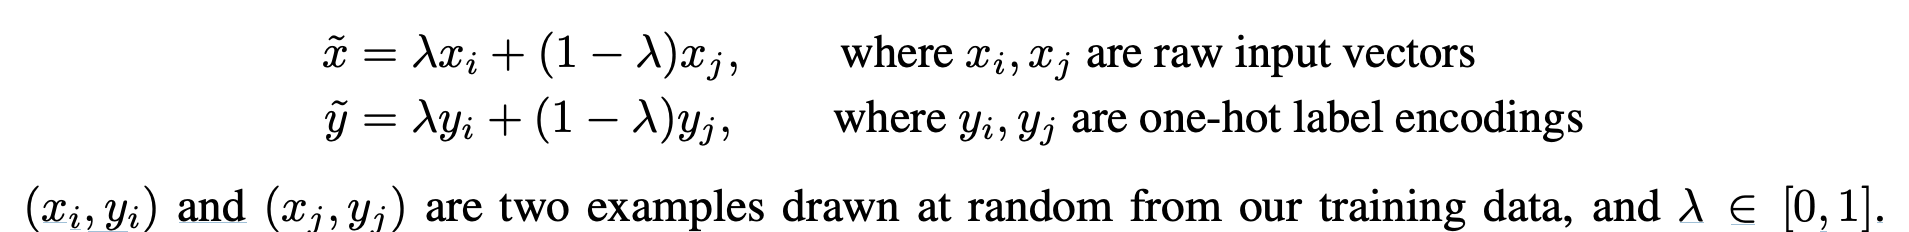

#### Αξιολόγηση του μοντέλου στο CIFAR-C

Για να καταλάβουμε περισσότερο τη χρησιμότητα του mixup και γενικότερα της επαύξησησς της κατανομής των δεδομένων εκπαίδευσης θα εκπαιδεύσουμε πάλι το μοντέλο μας στο CIFAR αλλά θα το κάνουμε evaluate στο CIFAR-C.

ΤοCIFAR-C παριέχει διάφορα corruptions (adversarial examples) στις εικόνες του αρχικού dataset, κάτι που το καθιστά πιο κοντά σε μια ρεαλιστική αξιολόγηση του μοντέλου.

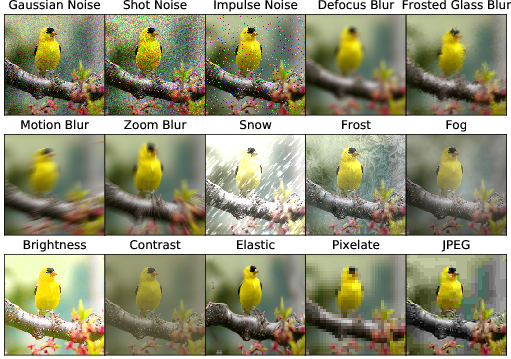


## device, corruption list

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

CORRUPTIONS = [
    'gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur',
    'glass_blur', 'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog',
    'brightness', 'contrast', 'elastic_transform', 'pixelate',
    'jpeg_compression'
]

## class Dataset

In [9]:
#### GRADED CELL ####

# Complete the following code and run the cell
class CIFAR_Dataset(Dataset):
    def __init__(self, data_dir, train, transform, mixup):
        self.data_dir = data_dir
        self.train = train
        self.transform = transform
        self.data = []
        self.targets = []
        self.mixup = mixup

        # Loading all the data depending on whether the dataset is training or testing
        if self.train:
            for i in range(5):
                with open(data_dir + 'data_batch_' + str(i+1), 'rb') as f:
                    entry = pickle.load(f, encoding='latin1')
                    self.data.append(entry['data'])
                    self.targets.extend(entry['labels'])
        else:
            with open(data_dir + 'test_batch', 'rb') as f:
                entry = pickle.load(f, encoding='latin1')
                self.data.append(entry['data'])
                self.targets.extend(entry['labels'])

        # Reshape it and turn it into the HWC format which PyTorch takes in the images
        # Original CIFAR format can be seen via its official page
        self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)
        self.data = self.data.transpose((0, 2, 3, 1))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        # Create a one hot label
        label = torch.zeros(10)
        label[self.targets[idx]] = 1.

        # Transform the image by converting to tensor and normalizing it
        if self.transform:
            image = transform(self.data[idx])

        # If data is for training, perform mixup, only perform mixup roughly on 1 for every 5 images
        if self.train and idx > 0 and self.mixup and idx%5 == 0:

            # Choose another image/label randomly
            mixup_idx = random.randint(0, len(self.data)-1)
            mixup_label = torch.zeros(10)
            mixup_label[self.targets[mixup_idx]] = 1.
            if self.transform:
                mixup_image = transform(self.data[mixup_idx])

            # Select a random number from the given beta distribution
            # Mixup the images accordingly
            ### Graded Part ###
            l = np.random.beta(1,1)
            image = l * image + (1 - l) * mixup_image
            label = l * label + (1 - l) * mixup_label

        return image, label

## val_cifar, test_cifar, test_c_cifar

In [10]:
# Evaluation scripts

def val_cifar(test_loader, net):
    """Evaluate network on given dataset."""
    net.eval()
    total_loss = 0.
    total_correct = 0
    with torch.no_grad():
        for images, targets in test_loader:
            images = images.to(device)
            targets = targets.to(device)


            logits = net(images)
            pred = logits.data.max(1)[1]
            #total_correct += pred.eq(targets.data).sum().item()
            total_correct += int((pred == torch.argmax(targets, dim=1)).float().sum())
    #print("len(test_loader.dataset)", len(test_loader.dataset))
    return total_correct / len(test_loader.dataset)


def test_cifar(test_loader, net, conf_scores):
    """Evaluate network on given dataset."""
    net.eval()
    params = list(net.parameters())
    total_loss = 0.
    total_correct = 0
    with torch.no_grad():
        for images, targets in test_loader:
            images = images.to(device)
            targets = targets.to(device)
            logits = net(images)
            #---------
            # add probabilities and label counts
            if conf_scores.current_epoch+1 == conf_scores.num_epochs:
                conf_scores.update_scores(logits, targets)
            #---------
            loss = F.cross_entropy(logits, targets)
            pred = logits.data.max(1)[1]
            total_loss += float(loss.data)
#             print(targets.data)
            total_correct += pred.eq(targets.data).sum().item()
    #print("len(test_loader.dataset)", len(test_loader.dataset))
    return total_loss / len(test_loader.dataset), total_correct / len(test_loader.dataset)


def test_c_cifar(net, conf_scores):
    """Evaluate network on given corrupted dataset."""
    base_path = '/content/drive/My Drive/Lab_DL_ex1/data/cifar/CIFAR-10-C/'
    normalize = transforms.Normalize([0.5] * 3, [0.5] * 3)
    test_transform = transforms.Compose(
        [transforms.ToTensor(), normalize])
    test_data = datasets.CIFAR10(
        '/content/drive/My Drive/Lab_DL_ex1/data/cifar/', train=False, transform=test_transform)
    corruption_accs = []
    Weather_accs = []
    Blur_accs = []
    Noise_accs = []
    Digital_accs = []
    weather_corr = ['snow', 'frost', 'fog']
    blur_corr = ['defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur']
    noise_corr = ['gaussian_noise', 'shot_noise', 'impulse_noise']
    digital_corr = ['brightness', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression']

    for corruption in CORRUPTIONS:
        # Reference to original data is mutated
        test_data.data = np.load(base_path + corruption + '.npy')[-10000:]  # take the level 5 severity only
        #pdb.set_trace()
        test_data.targets = torch.LongTensor(np.load(base_path + 'labels.npy')[-10000:])

        test_loader = torch.utils.data.DataLoader(
            test_data,
            batch_size=batch_size,
            shuffle=False,
            #num_workers=4,
            pin_memory=True)
        test_loss, test_acc = test_cifar(test_loader, net, conf_scores)
        corruption_accs.append(test_acc)
        if corruption in weather_corr:
            Weather_accs.append(test_acc)
        elif corruption in blur_corr:
            Blur_accs.append(test_acc)
        elif corruption in noise_corr:
            Noise_accs.append(test_acc)
        elif corruption in digital_corr:
            Digital_accs.append(test_acc)

        #print('{}\n\tTest Loss {:.3f} | Test Acc {:.3f}'.format(
        #    corruption, test_loss, test_acc))
    print('{}\n\t Test Acc {:.3f}'.format(
        'Weather', np.mean(np.array(Weather_accs))))
    print('{}\n\t Test Acc {:.3f}'.format(
        'Blur', np.mean(np.array(Blur_accs))))
    print('{}\n\t Test Acc {:.3f}'.format(
        'Noise', np.mean(np.array(Noise_accs))))
    print('{}\n\t Test Acc {:.3f}'.format(
        'Digital', np.mean(np.array(Digital_accs))))
    all_accs = []
    all_accs.append(np.mean(np.array(Weather_accs)))
    all_accs.append(np.mean(np.array(Blur_accs)))
    all_accs.append(np.mean(np.array(Noise_accs)))
    all_accs.append(np.mean(np.array(Digital_accs)))

    return np.mean(np.array(all_accs))

## utils

In [11]:
# Utils scripts
def save_checkpoint(state, dataset, exp_name, filename='checkpoint.pth.tar'):
    """Saves checkpoint to disk"""
    directory = "/content/drive/My Drive/Lab_DL_ex1/runs/%s/%s/" % (dataset, exp_name)
    if not os.path.exists(directory):
        os.makedirs(directory)
    filename = directory + filename
    torch.save(state, filename)


class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


def get_lr(step, total_steps, lr_max, lr_min):
  """Compute learning rate according to cosine annealing schedule."""
  return lr_min + (lr_max - lr_min) * 0.5 * (1 +
                                             np.cos(step / total_steps * np.pi))
def bceloss(x, y):
    eps = 1e-6
    return -torch.mean(y * torch.log(x + eps) + (1 - y) * torch.log(1 - x + eps))


## Confidence Scores class (Graded Cell)

In [17]:
#### GRADED CELL #### (Bonus)

class confidence_scores:

    def __init__(self, num_epochs):
        # create confidence scores as 10x10 tensor
        self.conf_scores = torch.zeros([10,10], device='cuda')
        self.label_counts = torch.zeros([10], device='cuda')
        self.current_epoch = 0
        self.num_epochs = num_epochs

    def update_scores(self, logits, targets):
        tmp_scores = torch.zeros([10,10], device='cuda')
        # logits -> probabilities
        probs = nn.Softmax(dim=1)(logits)

        # for every sample out of the minibatch (128)
        for sample_index in range(probs.shape[0]):

            # find the sample label (int)
            sample_label = targets[sample_index]

            # add probabilities to the column of the correct label
            tmp_scores[:, sample_label] += probs[sample_index]

            # find count of samples that truly belong in the class
            unique_vals, counts = torch.unique(targets, return_counts=True)

            # [0,0,0,0,0,0,0,0,0,0]
            tmp_freq = torch.zeros(10, dtype=torch.int64, device='cuda')

            # eg [3,4,2,6,4,1,0,6,5,0]
            tmp_freq[unique_vals] = counts

#             # [3,4,2,6,4,1,0,6,5,0] -> [3,4,2,6,4,1,1,6,5,1] to avoid zero division error
#             freq[freq == 0] = 1

#             # divide probabilities by class frequencies to get confidence scores of the minibatch
#             tmp_scores = tmp_scores / freq

        self.conf_scores  += tmp_scores
        self.label_counts += tmp_freq

    def divide(self):
        self.conf_scores = self.conf_scores / self.label_counts


## Train model without mixup

In [49]:
#### GRADED CELL ####

loaded_model = torch.load('/content/drive/My Drive/Lab_DL_ex1/runs/CIFAR-10/WRN-16-8-no_dropout/checkpoint.pth.tar', map_location='cuda')

num_epochs = 10

conf_scores_without_mixup = confidence_scores(num_epochs)

num_iters = 391 * num_epochs  # number of total epochs to run

batch_size = 128

print_freq = 391 # evaluation frequency (and log) (every epoch)

lr = 0.1  # learning rate
weight_decay = 0.0005

loaded_model = loaded_model.to(device)

optimizer = torch.optim.SGD(loaded_model.parameters(), lr, momentum=0.9, nesterov=True,
                                    weight_decay=weight_decay)
# scheduler_theta = torch.optim.lr_scheduler.StepLR(optimizer, step_size=60)
scheduler = torch.optim.lr_scheduler.LambdaLR(
  optimizer,
  lr_lambda=lambda step: get_lr(
      step,
      num_iters,
      1,
      1e-6 / lr))

criterion = nn.CrossEntropyLoss().cuda()

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_dataset = CIFAR_Dataset('/content/drive/My Drive/Lab_DL_ex1/data/cifar/cifar-10-batches-py/', 1, transform, False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = CIFAR_Dataset('/content/drive/My Drive/Lab_DL_ex1/data/cifar/cifar-10-batches-py/', 0, transform, False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Train loop
train_loader_iter = iter(train_loader)

counter_k = 0

epoch = 0
for t in range(0, num_iters+1):

    losses = AverageMeter()
    top1 = AverageMeter()
    loaded_model.train()

    try:
        input, target = next(train_loader_iter)
    except:
        train_loader_iter = iter(train_loader)
        input, target = next(train_loader_iter)
    #input, target = input.cuda(non_blocking=True).float(), target.cuda(non_blocking=True).long()
    imgs = input.to(device)
    labels = target.to(device)
    preds = loaded_model(imgs)
    preds = nn.Softmax(dim=1)(preds)
    loss = criterion(preds, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if t % print_freq == 0 and t >= print_freq:
        print("t = ", t)
        prec1 = val_cifar(val_loader, loaded_model)
        print("Epoch ", epoch)
        print("Validation set acc", prec1)
        # logfile.write('validation set acc: ' + str(prec1) + '\n')
        print('Average Cifar-C accuracy {}'.format(test_c_cifar(loaded_model, conf_scores_without_mixup)))
        epoch += 1
        conf_scores_without_mixup.current_epoch +=1

conf_scores_without_mixup.divide()

t =  391
Epoch  0
Validation set acc 0.8304
Weather
	 Test Acc 0.507
Blur
	 Test Acc 0.420
Noise
	 Test Acc 0.309
Digital
	 Test Acc 0.484
Average Cifar-C accuracy 0.4300083333333333
t =  782
Epoch  1
Validation set acc 0.7808
Weather
	 Test Acc 0.487
Blur
	 Test Acc 0.398
Noise
	 Test Acc 0.175
Digital
	 Test Acc 0.447
Average Cifar-C accuracy 0.37665375
t =  1173
Epoch  2
Validation set acc 0.8228
Weather
	 Test Acc 0.547
Blur
	 Test Acc 0.451
Noise
	 Test Acc 0.302
Digital
	 Test Acc 0.491
Average Cifar-C accuracy 0.44765791666666666
t =  1564
Epoch  3
Validation set acc 0.8383
Weather
	 Test Acc 0.504
Blur
	 Test Acc 0.423
Noise
	 Test Acc 0.308
Digital
	 Test Acc 0.499
Average Cifar-C accuracy 0.4334645833333334
t =  1955
Epoch  4
Validation set acc 0.8317
Weather
	 Test Acc 0.484
Blur
	 Test Acc 0.492
Noise
	 Test Acc 0.213
Digital
	 Test Acc 0.518
Average Cifar-C accuracy 0.42666124999999994
t =  2346
Epoch  5
Validation set acc 0.8355
Weather
	 Test Acc 0.504
Blur
	 Test Acc 0.

## Train model with mixup

In [13]:
#### GRADED CELL ####
# Train your best model with mixup and test on CIFAR-C

# Model parameters
num_epochs = 10
num_iters = 391 * num_epochs  # number of total epochs to run
batch_size = 128
print_freq = 391 # evaluation frequency (and log) (every epoch)

# load model
loaded_model = torch.load('/content/drive/My Drive/Lab_DL_ex1/runs/CIFAR-10/WRN-16-8-no_dropout/checkpoint.pth.tar', map_location='cuda')
confidence_scores_with_mixup = confidence_scores(num_epochs)

lr = 0.1  # learning rate
weight_decay = 0.0005

# loaded_model = WideResNet(layers, num_classes, widen_factor, droprate)

loaded_model = loaded_model.to(device)

optimizer = torch.optim.SGD(loaded_model.parameters(), lr, momentum=0.9, nesterov=True,
                                    weight_decay=weight_decay)
# scheduler_theta = torch.optim.lr_scheduler.StepLR(optimizer, step_size=60)
scheduler = torch.optim.lr_scheduler.LambdaLR(
  optimizer,
  lr_lambda=lambda step: get_lr(
      step,
      num_iters,
      1,
      1e-6 / lr))

criterion = nn.CrossEntropyLoss().cuda()

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_dataset = CIFAR_Dataset('/content/drive/My Drive/Lab_DL_ex1/data/cifar/cifar-10-batches-py/', 1, transform, True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = CIFAR_Dataset('/content/drive/My Drive/Lab_DL_ex1/data/cifar/cifar-10-batches-py/', 0, transform, True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


# Train loop
train_loader_iter = iter(train_loader)

counter_k = 0

epoch = 0
for t in range(0, num_iters+1):

    losses = AverageMeter()
    top1 = AverageMeter()
    loaded_model.train()

    try:
        input, target = next(train_loader_iter)
    except:
        train_loader_iter = iter(train_loader)
        input, target = next(train_loader_iter)
    #input, target = input.cuda(non_blocking=True).float(), target.cuda(non_blocking=True).long()
    imgs = input.to(device)
    labels = target.to(device)
    preds = loaded_model(imgs)
    preds = nn.Softmax(dim=1)(preds)
    loss = criterion(preds, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if t % print_freq == 0 and t >= print_freq:
        print("t = ", t)
        prec1 = val_cifar(val_loader, loaded_model)
        print("Epoch ", epoch)
        print("Validation set acc", prec1)
        # logfile.write('validation set acc: ' + str(prec1) + '\n')
        print('Average Cifar-C accuracy {}'.format(test_c_cifar(loaded_model, confidence_scores_with_mixup)))
        confidence_scores_with_mixup.current_epoch +=1
        epoch += 1

confidence_scores_with_mixup.divide()

t =  391
Epoch  0
Validation set acc 0.8134
Weather
	 Test Acc 0.490
Blur
	 Test Acc 0.374
Noise
	 Test Acc 0.311
Digital
	 Test Acc 0.474
Average Cifar-C accuracy 0.4120766666666667
t =  782
Epoch  1
Validation set acc 0.8034
Weather
	 Test Acc 0.596
Blur
	 Test Acc 0.388
Noise
	 Test Acc 0.329
Digital
	 Test Acc 0.478
Average Cifar-C accuracy 0.44791
t =  1173
Epoch  2
Validation set acc 0.817
Weather
	 Test Acc 0.480
Blur
	 Test Acc 0.464
Noise
	 Test Acc 0.162
Digital
	 Test Acc 0.484
Average Cifar-C accuracy 0.39753416666666663
t =  1564
Epoch  3
Validation set acc 0.789
Weather
	 Test Acc 0.425
Blur
	 Test Acc 0.468
Noise
	 Test Acc 0.124
Digital
	 Test Acc 0.495
Average Cifar-C accuracy 0.3781516666666667
t =  1955
Epoch  4
Validation set acc 0.8257
Weather
	 Test Acc 0.523
Blur
	 Test Acc 0.443
Noise
	 Test Acc 0.211
Digital
	 Test Acc 0.499
Average Cifar-C accuracy 0.41871916666666664
t =  2346
Epoch  5
Validation set acc 0.8167
Weather
	 Test Acc 0.472
Blur
	 Test Acc 0.321
N

# Μέρος 3 - Σχόλια

## Χωρίς Mixup
<font color='blue'><h5>
Χρησιμοποιώντας το μοντέλο WRN-16-8 και κάνοντας εκπαίδευση για 10 εποχές, λαμβάνουμε για δεδομένα χωρίς mixup μέση ακρίβεια στο CIFAR-C: 42.25%. Ωστόσο, παρατηρούμε ότι δεν υπάρχει βελτίωση σε σχέση με την πρώτη εποχή, αλλά η ακρίβεια ταλαντώνεται γύρω από μια σταθερή τιμή. .
</font>

## Χωρίς Mixup
<font color='blue'><h5>
Χρησιμοποιώντας το μοντέλο WRN-16-8 και κάνοντας εκπαίδευση για 10 εποχές, λαμβάνουμε για δεδομένα χωρίς mixup μέση ακρίβεια στο CIFAR-C: 40.27%. Πάλι, παρατηρούμε ότι το δίκτυο δεν εκπαιδεύεται, καθώς καταλήγει σε παρόμοιο test accuracy με αυτό που ξεκίνησε.<br>
Η έλλειψη βελτίωσης του test accuracy, μετά από 10 εποχές, ενδεχομένως οφείλεται σε:
*   μικρό αριθμό εποχών εκπαίδευσης.
*   στο γεγονός ότι κάνουμε εκπαίδευση μόνο στο dataset Cifar, χωρίς να δώσουμε παραδείγματα από το Cifar-C.
*   στο ότι για testing χρησιμοποιούμε μόνο τις πιο distorted εικόνες από κάθε είδος corruption του Cifar-C.
*   έλλειψη χρήσης mixup, στο dataset που εκπαιδεύεται.

</font>

# Mέρος 4

In [15]:
def create_heatmap(conf_scores):
    conf_scores = conf_scores.conf_scores.cpu().numpy()
    a = pd.DataFrame(conf_scores, range(10), range(10))
    plt.figure(figsize=(12,12))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(a, annot=True, annot_kws={"size": 16}, cmap='coolwarm') # font size
    plt.show()


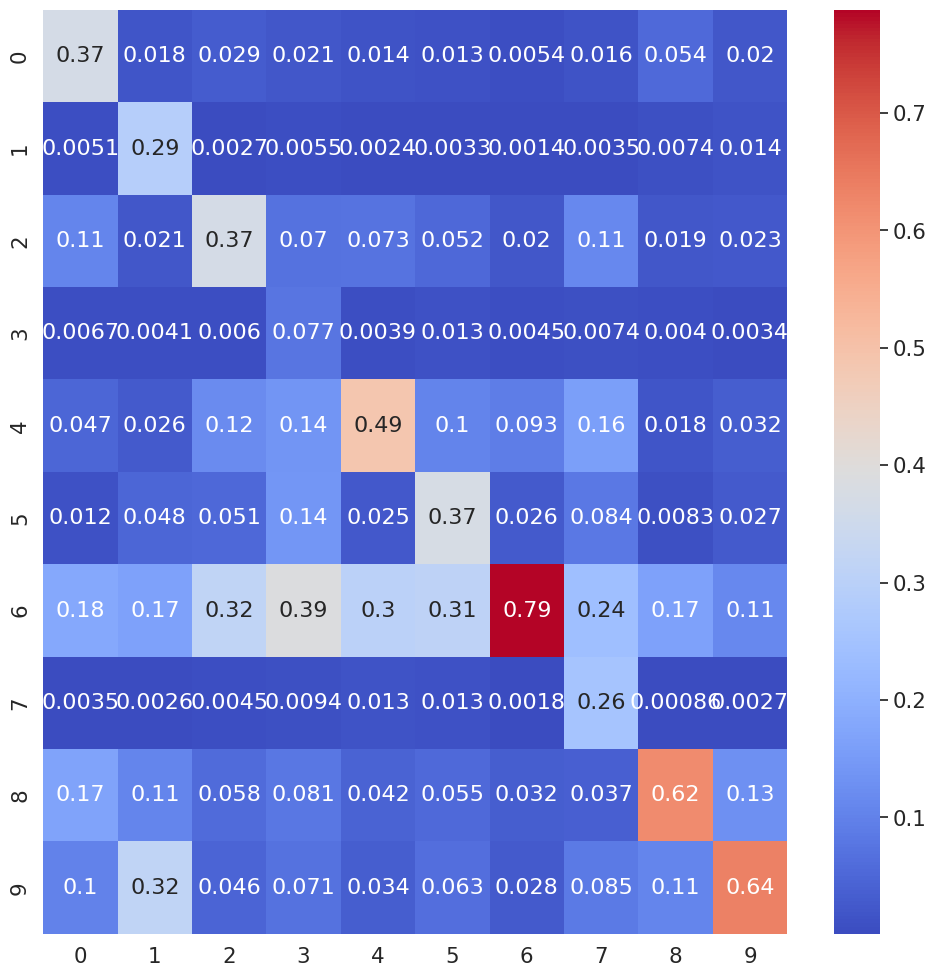

In [51]:
# Plot the confidence scores for CIFAR-C with WRN model without mixup

create_heatmap(conf_scores_without_mixup)

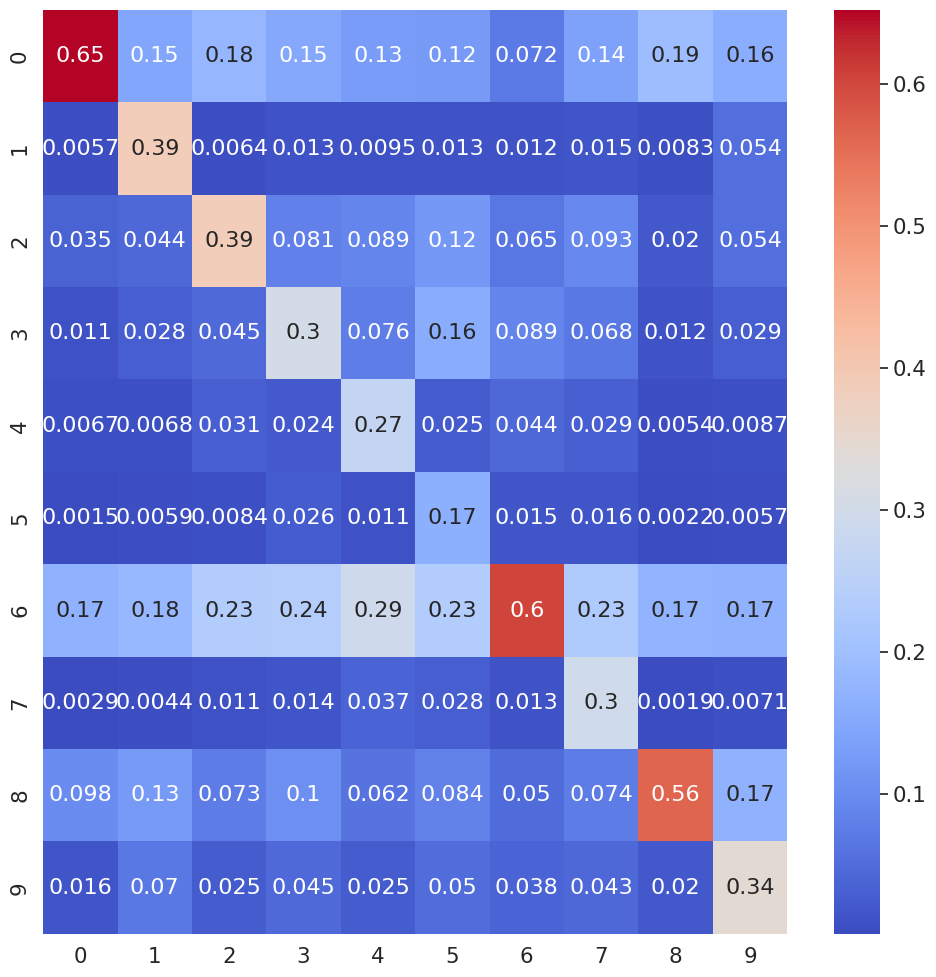

In [16]:
# Plot the confidence scores for CIFAR-C with WRN model with mixup

create_heatmap(confidence_scores_with_mixup)

# Mέρος 4
Παρατηρούμε ότι ενώ θα έπρεπε να κυριαρχούν οι πιθανότητες στην κύρια διαγώνιο, έχουμε μεγάλη διασπορά μεταξύ των 10 κατηγοριών, γεγονός που συνάδει με την κακή ακρίβεια που παρατηρούμε στο μέρος 3, με ή χωρίς τη χρήση mixup.